# Convolutional Neural Network for a Reptile-Amphibian Clasificator using PyTorch.  
## Fine-Tuning to Resnet50. Colab Training with GPU.

### The data is already formated and uploaded to a Google Drive account for that it would be easier to mange online. The Grouping and Data Augmentation was made offline.

### Let's start by uploading the Dataset from the Google Drive account. It is divided into 2 folders of classified images: "Amphibians" and "Reptiles".

In [25]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set main_route to the path of the folder in the Drive account
main_route = '/content/drive/My Drive/Colab Notebooks/ProyectoML/dataset'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Let's see how many images of each class we have

In [19]:
import os

main_route = '/content/drive/My Drive/Colab Notebooks/ProyectoML/dataset'

# Number of images on each subfolder
counts = {}
for folder in os.listdir(main_route):
    folder_route = os.path.join(main_route, folder)
    if os.path.isdir(folder_route):
        image_number = len([file for file in os.listdir(folder_route) if os.path.isfile(os.path.join(folder_route, file))])
        counts[folder] = image_number

# Print the number of images per folder
for folder, count in counts.items():
    print(f"Folder '{folder}': {count} images")

Folder 'Reptiles': 8968 images
Folder 'Amphibians': 6999 images


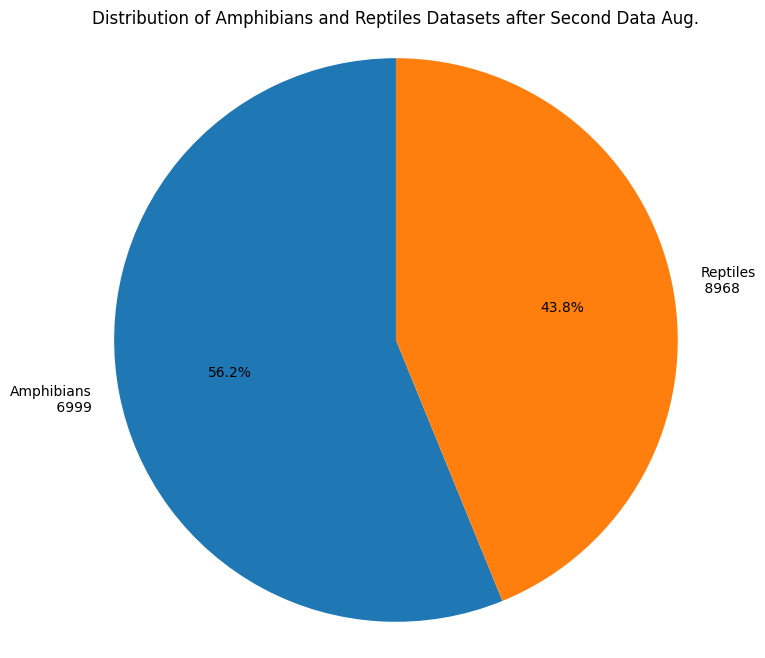

In [38]:
import matplotlib.pyplot as plt

# Data
sizes = list(counts.values())
labels = [f"Amphibians\n {sizes[0] if sizes[0]==counts['Amphibians'] else sizes[1]}", f"Reptiles\n {sizes[0] if sizes[0]==counts['Reptiles'] else sizes[1]}"]

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Amphibians and Reptiles Datasets after Second Data Aug.')
plt.show()

#### Let's load the images and divide them into training and validation

In [12]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split

# Images Transformations
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = torchvision.datasets.ImageFolder(root=main_route, transform=transformations)

# Size of the Training and Validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size

# Split the dataset into Training and Validation
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training: {len(train_dataset)} images, Validation: {len(test_dataset)} images")


Training: 12772 images, Validation: 3194 images


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Let's load the Resnet50 and start training.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

# Loading the pretrained model
model = models.resnet50(pretrained=True)

# Freezing the parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer fully connected
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 outputs: Amphibians and Reptiles

# Defining the training device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda:0


In [15]:
import matplotlib.pyplot as plt
# Define the loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# DataLoader for training and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


def calculate_presicion(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item()

def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    train_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += calculate_presicion(outputs, labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    return model, train_loss_history, train_acc_history

### First Training

In [16]:
trained_model, loss_history, acc_history = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.2063, Accuracy: 0.9197
Epoch 2/10, Loss: 0.1475, Accuracy: 0.9493
Epoch 3/10, Loss: 0.1529, Accuracy: 0.9460
Epoch 4/10, Loss: 0.1392, Accuracy: 0.9505
Epoch 5/10, Loss: 0.1466, Accuracy: 0.9485
Epoch 6/10, Loss: 0.1397, Accuracy: 0.9486
Epoch 7/10, Loss: 0.1364, Accuracy: 0.9518
Epoch 8/10, Loss: 0.1263, Accuracy: 0.9540
Epoch 9/10, Loss: 0.1275, Accuracy: 0.9531
Epoch 10/10, Loss: 0.1257, Accuracy: 0.9544


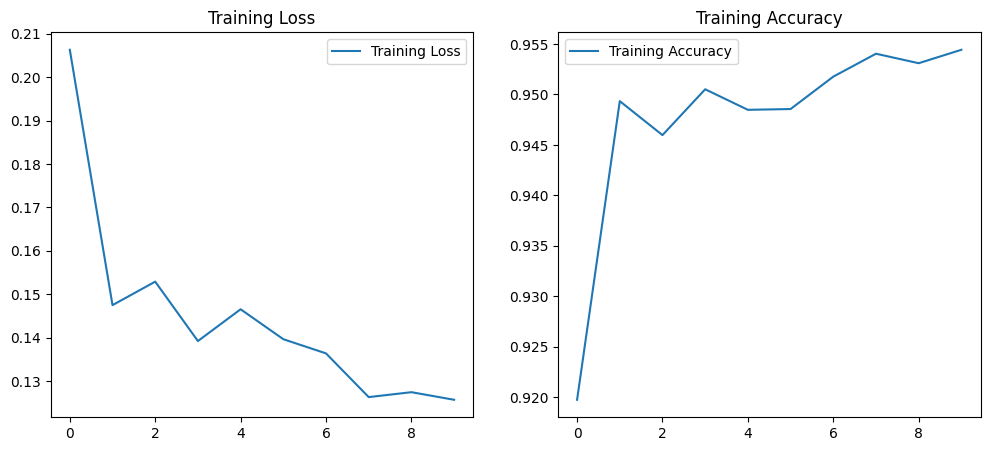

In [20]:
# Graph Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

### Second Training

In [22]:
# Unfreeze all layers of the model
for param in model.parameters():
    param.requires_grad = True

# Define the optimizer again (now for all layers)
optimizer_fine_tuning = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate

# We will reuse the previous training function

# Fine-tuning of the model
trained_model_fine_tuned, loss_history_fine_tuned, acc_history_fine_tuned = train_model(
    model, criterion, optimizer_fine_tuning, num_epochs=5)  # Reduced number of epochs for fine-tuning

Epoch 1/5, Loss: 0.1400, Accuracy: 0.9509
Epoch 2/5, Loss: 0.0606, Accuracy: 0.9777
Epoch 3/5, Loss: 0.0470, Accuracy: 0.9843
Epoch 4/5, Loss: 0.0450, Accuracy: 0.9854
Epoch 5/5, Loss: 0.0343, Accuracy: 0.9890


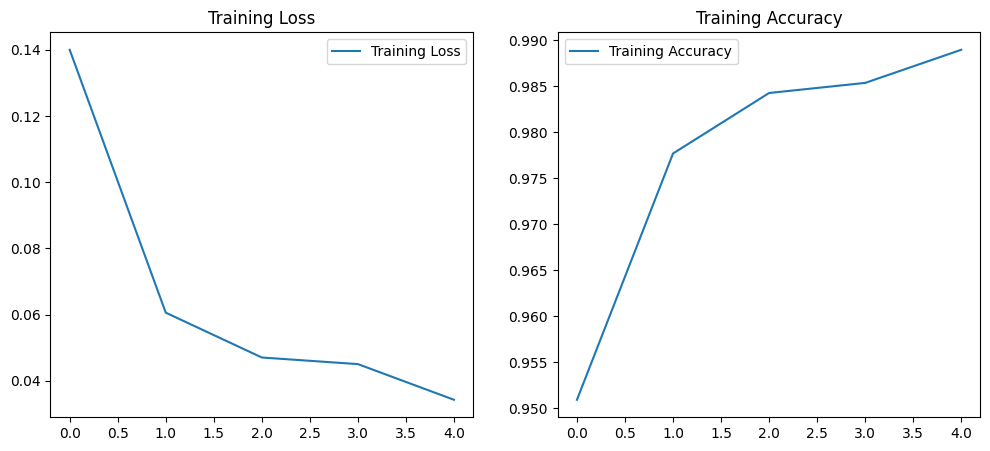

In [23]:
# Graph Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history_fine_tuned, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(acc_history_fine_tuned, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

### Saving the model

In [30]:
torch.save(model.state_dict(), F"/content/drive/My Drive/Colab Notebooks/ProyectoML/resnet50_amphibians_reptiles_colab.pth")

# download checkpoint file
from google.colab import files
files.download('/content/drive/My Drive/Colab Notebooks/ProyectoML/resnet50_amphibians_reptiles_colab.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Let's show some interesting data:

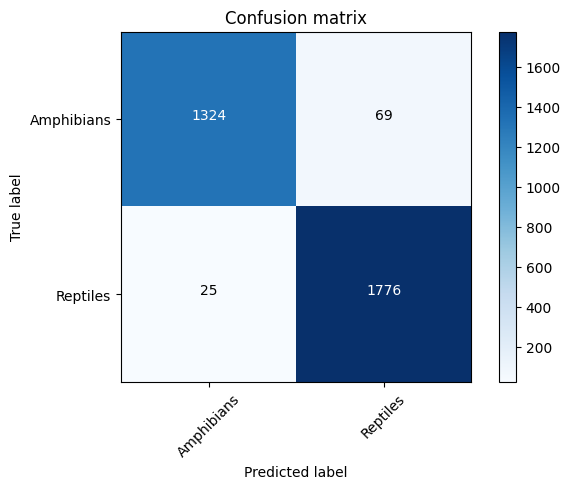

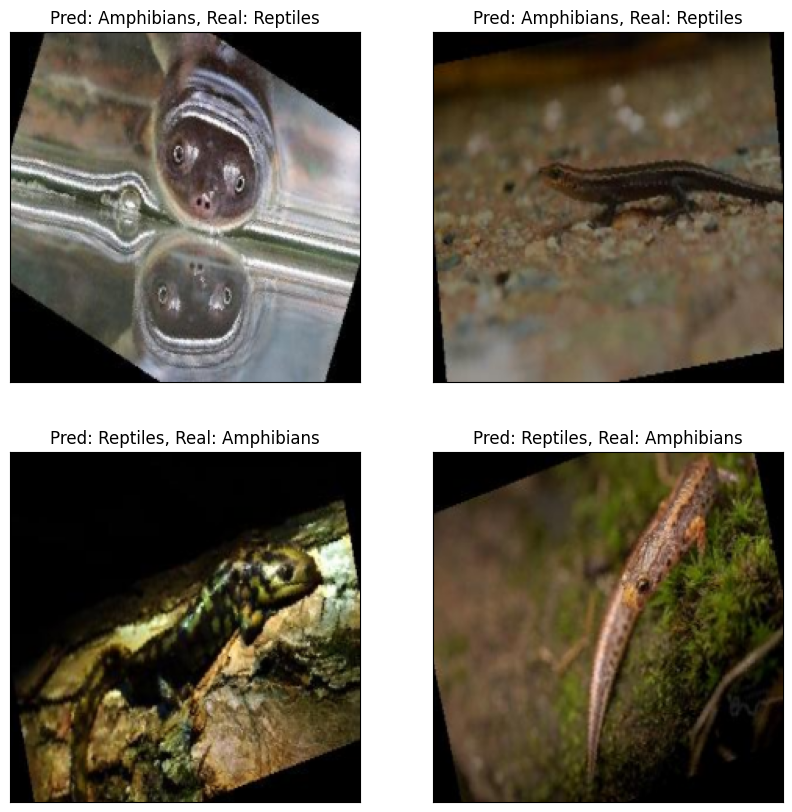

In [35]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to display the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Calculate predictions
y_pred = []
y_true = []

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.view(-1).tolist())
        y_true.extend(labels.view(-1).tolist())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['Amphibians', 'Reptiles'])

# Show wrong predictions
fig = plt.figure(figsize=(10, 10))

incorrects = np.where(np.array(y_pred) != np.array(y_true))[0]
if incorrects.size > 0:
    for i, incorrect in enumerate(incorrects[:4]):  # Show only the first 4
        ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
        img, label = test_dataset[incorrect]
        img = img.cpu().numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(f'Pred: {["Amphibians", "Reptiles"][y_pred[incorrect]]}, Real: {["Amphibians", "Reptiles"][y_true[incorrect]]}')

plt.show()